# Final Analysis and Cascading Kalman Filter Design

In [1]:
%matplotlib ipympl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import sympy as sp

In [2]:
# Auto reload changed mods.
%load_ext autoreload
%autoreload 2

In [3]:
# Add srcs mods to nbs.
from importlib.util import find_spec
if find_spec("analysis") is None:
    import sys
    print("appending kalman path ...")
    sys.path.append("../kalman")

appending kalman path ...


In [13]:
stat_acc_csv_path = "../data/stationary_acc.csv"
stat_gyr_csv_path = "../data/stationary_gyr.csv"
traj_acc_csv_path = "../data/traj_acc.csv"
traj_gyr_csv_path = "../data/traj_gyr.csv"
traj_gps_csv_path = "../data/traj_gps.csv"
traj_truth_csv_path = "../data/traj_truth.csv"

In [23]:
stat_acc_df = pd.read_csv(stat_acc_csv_path)
stat_gyr_df = pd.read_csv(stat_gyr_csv_path)
traj_acc_df = pd.read_csv(traj_acc_csv_path)
traj_gyr_df = pd.read_csv(traj_gyr_csv_path)
traj_gps_df = pd.read_csv(traj_gps_csv_path)
traj_truth_df = pd.read_csv(traj_truth_csv_path)

# Allanvariance Analysis of IMU Sensor

References:
- https://en.wikipedia.org/wiki/Allan_variance
- https://www.mathworks.com/help/nav/ug/inertial-sensor-noise-analysis-using-allan-variance.html

In [12]:
from analysis.allanvar import analyse_acc_with_allan, analyse_gyr_with_allan
from analysis.bias import find_acc_bias_model, find_gyr_bias_model

## Accelerometer White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Accelerometer's yaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

Sampling properties: 0.05s, 20.0Hz
White-noise Slope: -0.4983117270444709


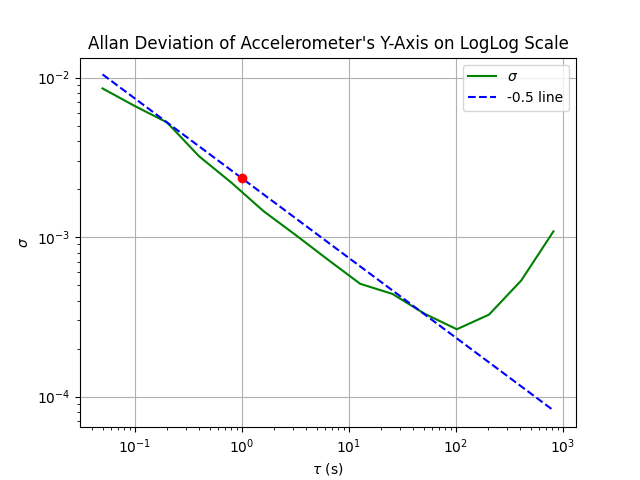

In [21]:
analyse_acc_with_allan(stat_acc_csv_path)

> As seen the white noise is approximately Gaussian.

## Gyro White Noise Analysis

Deliverables:
- Allanvariance loglog plot of Gyro's zaxis
- Find slope of white noise porition and verify that its Gaussian (m = -0.5) 

Sampling properties: 0.05s, 20.0Hz
White-noise Slope: -0.5019260375250464


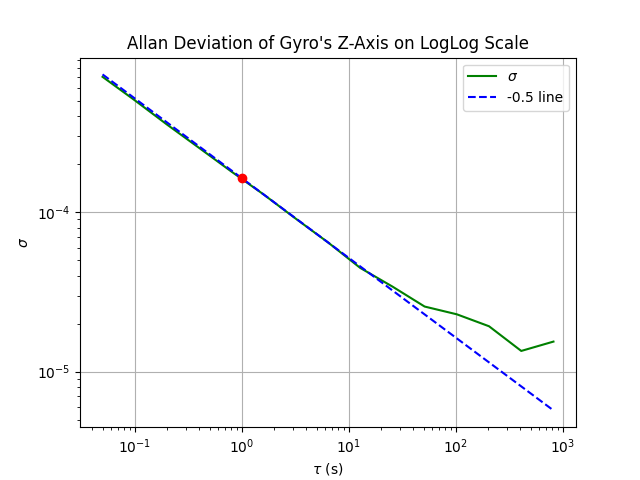

In [22]:
analyse_gyr_with_allan(stat_gyr_csv_path)

> As seen the white noise is approximately Gaussian.


# Bias Classification using Linear Regression

References:
- https://en.wikipedia.org/wiki/Linear_regression
- https://en.wikipedia.org/wiki/Least_squares

## Accelerometer Bias Model

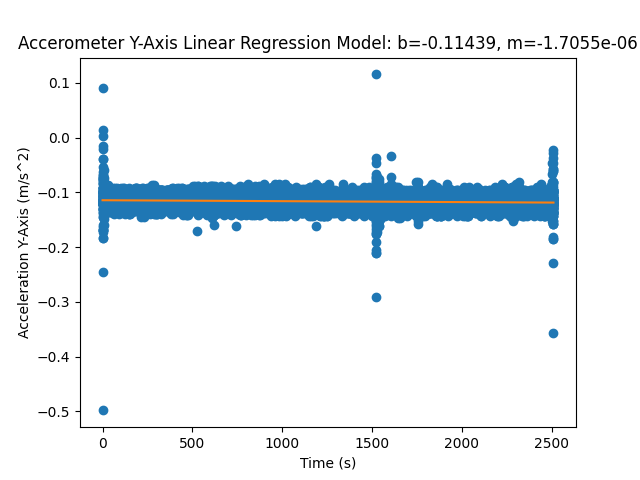

Initial bias (b): -0.11439193955665476
Time-varying bias (b): -1.7055461301349091e-06


In [26]:
acc_yaxis_bias = find_acc_bias_model(stat_acc_csv_path)

## Gyro Bias Model

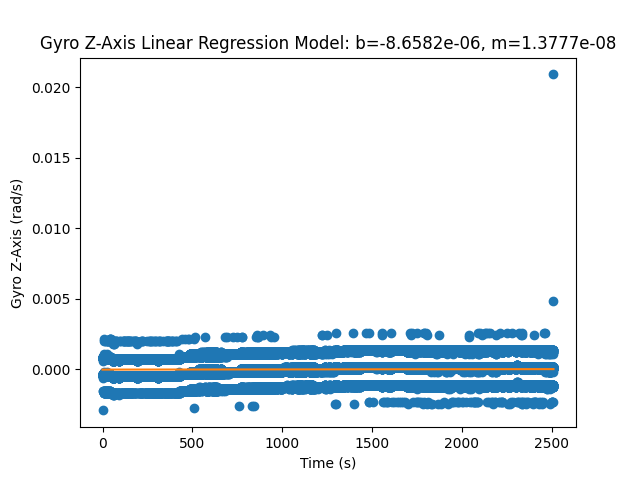

Initial bias (b): -8.658192402998033e-06
Time-varying bias (b): 1.3776831294804729e-08


In [27]:
gyr_zaxis_bias = find_gyr_bias_model(stat_gyr_csv_path)

## Accelerometer Noise Expected Value and Variance

In [30]:
stat_acc_df.describe()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.244651,0.076074,-0.116533,9.757696
std,724.697275,0.007860,0.009195,0.011075
min,0.069651,-0.141775,-0.498305,9.490533
25%,627.657151,0.071186,-0.123230,9.751350
50%,1255.244651,0.075972,-0.116650,9.757333
75%,1882.832151,0.080758,-0.110668,9.766306
max,2510.419651,0.185444,0.115454,10.130613


In [32]:
stat_acc_yaxis_vec = stat_acc_df.loc[:, "Acceleration y (m/s^2)"].to_numpy()
print(f"ACC Biased Mean: {np.mean(stat_acc_yaxis_vec)}, ACC Biased Var: {np.var(stat_acc_yaxis_vec)}")
print(f"ACC Non-Biased Mean: {np.mean(stat_acc_yaxis_vec - acc_yaxis_bias)}, ACC Non-Biased Var: {np.var(stat_acc_yaxis_vec - acc_yaxis_bias)}")

ACC Biased Mean: -0.11653281721361536, ACC Biased Var: 8.455227340409606e-05
ACC Non-Biased Mean: -8.437960336822468e-15, ACC Non-Biased Var: 8.302459638044139e-05


> Non-Biased Noise Mean: $$E[\nu(t)] = -8.43796e^{-15}$$

> Noise Var: $$E[\nu^2(t)] = 8.30246e^{-5}$$

## Gyro Noise Expected Value and Variance

In [33]:
stat_gyr_df.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,50208.000000,50208.000000,50208.000000,50208.000000
mean,1255.259551,-0.000013,0.000007,0.000009
std,724.697275,0.002788,0.001189,0.000714
min,0.084551,-0.357814,-0.092546,-0.002902
25%,627.672051,-0.000458,-0.000764,-0.000305
50%,1255.259551,-0.000305,0.000305,-0.000000
75%,1882.847051,0.000916,0.000458,0.000153
max,2510.434551,0.460440,0.063683,0.020922


In [34]:
stat_gyr_zaxis_vec = stat_gyr_df.loc[:, "Gyroscope z (rad/s)"].to_numpy()
print(f"GYR Biased Mean: {np.mean(stat_gyr_zaxis_vec)}, GRY Biased Var: {np.var(stat_gyr_zaxis_vec)}")
print(f"GYR Non-Biased Mean: {np.mean(stat_gyr_zaxis_vec - gyr_zaxis_bias)}, GRY Non-Biased Var: {np.var(stat_gyr_zaxis_vec - gyr_zaxis_bias)}")

GYR Biased Mean: 8.635306662878425e-06, GRY Biased Var: 5.102994014769565e-07
GYR Non-Biased Mean: 2.9351543326000184e-18, GRY Non-Biased Var: 5.10199722565478e-07


> Non-Biased Noise Mean: $$E[\nu(t)] = 2.93515e^{-18}$$

> Noise Var: $$E[\nu^2(t)] = 5.101997e^{-7}$$